# Optimisation Hands-On

This notebook is part of a training session on implementing meta-heuristic techniques to solve optimisation problems, in this case the Traveling Salesman problem.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [3]:
file = "http://www.math.uwaterloo.ca/tsp/world/wi29.tsp"
raw_dataset = pd.read_csv(file, sep="\t")
raw_dataset.head(10)

,NAME : wi29
0,COMMENT : 29 locations in Western Sahara
1,COMMENT : Derived from National Imagery and Ma...
2,TYPE : TSP
3,DIMENSION : 29
4,EDGE_WEIGHT_TYPE : EUC_2D
5,NODE_COORD_SECTION
6,1 20833.3333 17100.0000
7,2 20900.0000 17066.6667
8,3 21300.0000 13016.6667
9,4 21600.0000 14150.0000


In [4]:
raw_dataset.tail()

,NAME : wi29
31,26 27233.3333 11783.3333
32,27 27266.6667 10383.3333
33,28 27433.3333 12400.0000
34,29 27462.5000 12992.2222
35,EOF


## Data cleaning

Our dataset is not very clean (which is almost always the case), so let's clean this up. A line like `1 20833.3333 17100.0000` is the actual data we are interested in, the `1` is the `city_id`, the second number `20833.3333` and the last number `17100.000` are the `x` and `y`coordinates of the city. (In this dataset latitudes and longitudes are projected onto a 2d x-y plane). The first 6 rows is information about the dataset, so our data actually starts on row 7 (index `6`). 

In [5]:
tsp_dataset = pd.DataFrame(raw_dataset.loc[6:, raw_dataset.columns[0]])
tsp_dataset.columns = ["raw_data"]
tsp_dataset.drop(35, inplace=True) #is EOF (end of file) - we don't need this in our dataset
tsp_dataset.head()

,raw_data
6,1 20833.3333 17100.0000
7,2 20900.0000 17066.6667
8,3 21300.0000 13016.6667
9,4 21600.0000 14150.0000
10,5 21600.0000 14966.6667


In [6]:
tsp_dataset.tail()

,raw_data
30,25 27233.3333 10450.0000
31,26 27233.3333 11783.3333
32,27 27266.6667 10383.3333
33,28 27433.3333 12400.0000
34,29 27462.5000 12992.2222


In [7]:
def split_into_columns(row):
    splitted = row.str.split(" ").values # split returns series, values returns numpy array
    splitted = splitted[0] # we want the list in the numpy array
    # str.split returns a string, so while the values may seem numerical they are actually strings. We can convert them 
    # either now, or later. Let's do it now. 
    row["city_id"] = int(splitted[0])
    row["y"] = float(splitted[1]) # mathematically latitude is x and longitude is y
    row["x"] = float(splitted[2])
    del row["raw_data"] # we don't need this column anymore
    return row
    
    
tsp_dataset = tsp_dataset.apply(lambda x: split_into_columns(x),axis=1)

In [8]:
tsp_dataset.head()

,city_id,y,x
6,1,20833.3333,17100.0000
7,2,20900.0000,17066.6667
8,3,21300.0000,13016.6667
9,4,21600.0000,14150.0000
10,5,21600.0000,14966.6667


We could technically reindex, but that is not necessary for what we are going to do next

In [9]:
tsp_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 6 to 34
Data columns (total 3 columns):
city_id    29 non-null int64
y          29 non-null float64
x          29 non-null float64
dtypes: float64(2), int64(1)
memory usage: 928.0 bytes


Our columns are numerical, good!

## Exploration
Let's visualise our dataset

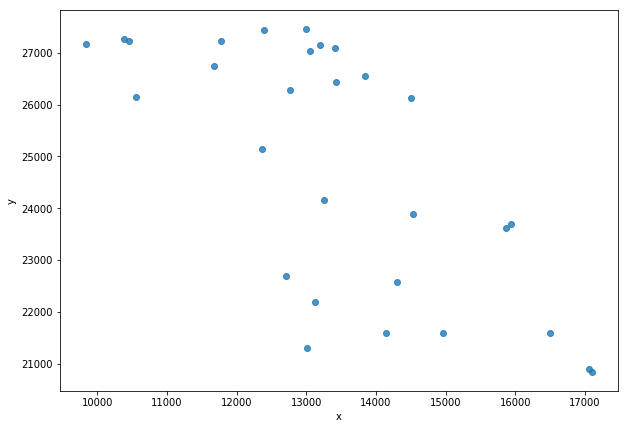

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.regplot(data=tsp_dataset, x="x", y="y", fit_reg=False)
plt.show()

## Domain modeling
Let's model our problem. We are solving the Traveling Salesman Problem. The aim is to visit every city in our dataset exactly once in one single tour that is the shortest overall route. We have 29 cities which gives us `29!` possible combinations for this problem. Trying every possible combination will take forever, even on moden computers. So we need a _smarter_ way to go about this problem. How we are going to model is as follows, we need a:

* `City`: To hold any logic regarding a city. (In this problem it is just the x and y coordinate of the city, but in more sophisticated versions of this problem this could also be a time window for example).
* `Route`: A route is a sequence of cities to be visited. We can model route modifications into this class.
* `TspProblem`: We are trying to solve the tsp problem, this will be a representation of the problem and we can put all the logic to solve it into this class. 
* `ScoreCalculator`: We need to be able to calculate the shortest distance. To that end we will devise a score class that can compute the distance of any route. While this is not a must, it makes our code quite modular and we can put any logic to evaluate a solution on in this class. 

Note that according to our data source, the distance between two cities is the eucledian distance but rounded. 
```
For these instances, the cost of travel between cities is specified by the Eulidean distance rounded to the nearest whole number (the TSPLIB EUC_2D-norm).
```



In [21]:
class City:
    def __init__(self, city_id, x, y):
        """
        This class is a representation of a city. It holds the city id, the x and y coordinates. 
        
        :param city_id: int the city id
        :param x: float, the x coordinate
        :param y: float, the y coordinate
        """
        self.id = int(city_id)
        self.x = x
        self.y = y
    
    def __repr__(self):
        return str(self.x) + ", " +  str(self.y)
    
        
        
class Route:
    def __init__(self):
        """
        This class is a representation of a route. It is a sequence of cities, to this end we will make use of a list.
        
        :param sequence: list, the route
        """
        self.sequence = []
        
    def add(self, city):
        """
        A convenience method to add a city to our route object.
        
        :param city: City, the city to add to the route
        """
        self.sequence.append(city)
    
    def get_first_city(self):
        return self.sequence[0]
    
    def get_last_city(self):
        return self.sequence[len(self.sequence)-1]
    
    def swap(self):
        raise NotImplementedError("This method is not yet implemented")
        
    def copy(self):
        """
        Copies the route
        """
        route = Route()
        for city in self.sequence:
            route.add(city)
        return route
    
    def score(self, scorer):
        return scorer.score(self)
        
    
class ScoreCalculator:
    def __init__(self):
        """
        This class computes the distance of any route.
        """
        pass
        
    def score(self, route):
        """
        Calculates the total distance of a route. It computes the distance as a full tour by also computing the trip
        from the last node in the route to the first node (closed tour). The score between two nodes is computed using
        rounded Eucledian distance.
        
        :param route: Route, the route to evaluate
        """
        distance = 0
        sequence = route.sequence
        # let's loop over the route
        for i in range(1, len(sequence)):
            previous_city = sequence[i-1]
            current_city = sequence[i]
            distance += np.round(
                sp.spatial.distance.euclidean((previous_city.x, previous_city.y), (current_city.x, current_city.y)))
        
        # We need to close the loop
        first_city = route.get_first_city()
        last_city = route.get_last_city()
        distance += np.round(
            sp.spatial.distance.euclidean((first_city.x, first_city.y), (last_city.x, last_city.y)))
        return distance

We now have most of our modelling ready, let's see how this works. 

Let's create our route object and city objects.

In [16]:
route = Route() #creates an empty route

# let's loop over our dataset and create a city object for each row
for index, row in tsp_dataset.iterrows():
    route.add(City(row["city_id"], row["x"], row["y"]))
print("# of cities", len(route.sequence))

# of cities 29


We can access our route through `route.sequence`. So far, so good; our modelling seems to work! Let's see how our score calculator works. 

In [20]:
# We build a score object
score_calculator = ScoreCalculator()

# We pass a route object to the score method, which then returns a value for the score. 
distance = score_calculator.score(route)
print(distance)

52284.0


Alright, that works. Perhaps we are interested in visualising our result ? Let's write a function that can do that.

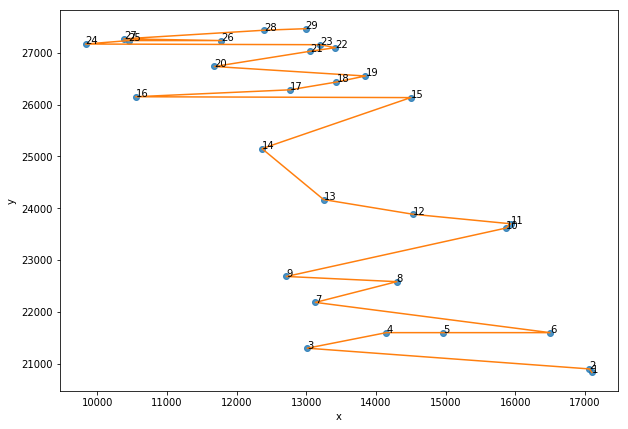

In [29]:
def plot_route(df, route=None):
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.regplot(data=df, x="x", y="y", fit_reg=False)
    if route is not None:
        x_values = []
        y_values = []
        for city in route.sequence:
            ax.text(city.x, city.y, int(city.id)) # add a label
            x_values.append(city.x)
            y_values.append(city.y)
        
        plt.plot(x_values, y_values)
    plt.show()

plot_route(tsp_dataset, route=route)

Note that while the route doesn't close we do close it on our calculation, we just don't visualise it. 

So we have created a route that goes from city with index `1` to the city with index `29`. Obviously this is a very bad route and we can come to that conclusin easily from our plot and our score. The score is double the distance of the best route `27603`. 

One piece is missing in our modeling: The modeling of the problem itself.

In [23]:
# first let's create our cities and collect them in a list, we will need this later
cities = [] 
for index, row in tsp_dataset.iterrows():
    cities.append(City(row["city_id"], row["x"], row["y"]))

In [25]:
class TspProblem:
    def __init__(self, cities, scorer=None):
        """
        A representation of the tsp problem. Takes a list of cities to construct the problem.
        
        :param cities: List A list of City objects
        :param scorer: ScoreCalculator a score calculator to evaluate a route on
        """
        self.cities = cities
        self.scorer = scorer
        self._initialize()
    
    def _initialize(self):
        """
        Initialises a random route
        """
        cities = self.cities.copy()
        np.random.shuffle(cities) # shuffles in place and does not return anything
        route = Route()
        for city in cities:
            route.add(city)
        self.route = route
        
    def solve(self, method="hill_climbing"):
        """
        Solves the tsp problem. Accepted methods are hill_climbing and tabu_search.
        """
        if method == "hill_climbing":
            self._run_hill_climbing()
        elif method == "tabu_search":
            self._run_tabu_search()
        else:
            raise NotImplementedError(method + " is not yet supported")
            
    def _run_hill_climbing(self, nr_of_iterations=10):
        """
        Runs the Hill Climbing algorithm
        """
        raise NotImplementedError(method + " is not yet implemented")
        # Remove the raise line and implemented the hill_climbing algorithm
        
    def _run_tabu_search(self, nr_of_iterations=10):
        """
        Runs the Tabu Search algorithm
        """
        raise NotImplementedError(method + " is not yet implemented")
        # Remove the raise line and implemented the tabu_search algorithm
            
    def visualize(self, best=False):
        if self.route is not None:
            if best:
                if self.best_route is None:
                    raise RuntimeError("The best route has not been set for this problem. Set this first before visualising the best route.")
                plot_route(tsp_dataset, self.best_route)
            else:
                plot_route(tsp_dataset, self.route)
        else:
            raise RuntimeError("You are trying to visualise an unitialized route. First initialise a route by calling initialise()")
    
    def evaluate(self, scorer):
        return scorer.score(self.route)

Let's initialise our problem.

In [27]:
problem = TspProblem(cities) # we create a new 'problem' object here
problem.evaluate(ScoreCalculator())

104354.0

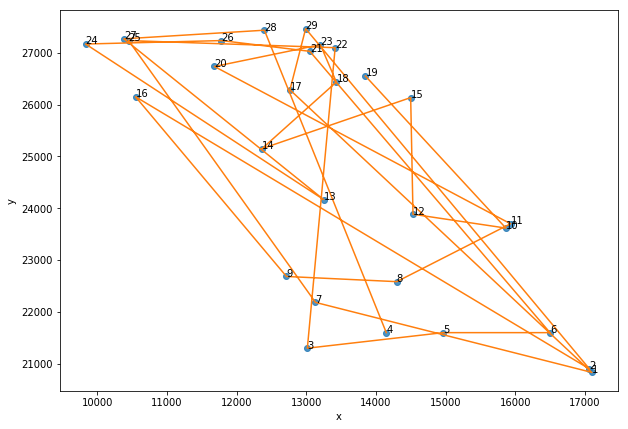

In [30]:
problem.visualize()

Okay, so if we do a random intialisation of the route , it obviously looks horrible! We want to optimise this. To do so, we want to implement two algorithms (1) Hill Climbing and (2) Tabu Search. 

Here are 2 links that describe the algorithms: 
* https://www.geeksforgeeks.org/introduction-hill-climbing-artificial-intelligence/
* https://image.slidesharecdn.com/a5c35bd0-23dc-4cbf-ad1e-89d5937b4b88-150102173323-conversion-gate02/95/tabusearch-final-11-638.jpg?cb=1420220092

Note that we need to implement functions that can explore the `neighbourhood` of a solution, i.e. a route. A neighbourhood is defined as a a collection of solutions, i.e. another route, that we can reach from our current solution by modifying its state. A very simple modification would be to swap the position of two cities in an already existing route.

In Python we could do this as:

```
sequence = [1, 2, 3, 4, 5]

def swap(index_1, index_2):
    sequence[index_1], sequence[index_2] = sequence[index_2], sequence[index_1]
```

The code above could be a way to simply modify a sequence by swapping two cities based on two indices. The best place to impement this would be in the class `Route`. A method (function) like `def swap(self, index_1, index_2)` that does the same as the code above would modify the route in the problem. Try to implement `swap` and see if you can think of other methods to modify the route.

Hint: here is an overview of neighbourhood exploring moves
* https://en.wikipedia.org/wiki/2-opt
* https://en.wikipedia.org/wiki/3-opt
* https://en.wikipedia.org/wiki/Lin%E2%80%93Kernighan_heuristic

## Your implementation
Copy the classes above and modify them to implement the algorithms to optimise.